In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import recall_score, balanced_accuracy_score, confusion_matrix, classification_report

## 1. Load data, visualise it and identify erroneous values

### 1.1 Load and display the data

In [2]:
#Load the data
df_diabetes = pd.read_csv('diabetes.csv')
df_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# Take a look on the data information
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Take a look on the data
df_diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### 1.2 Visualise the data and identify erroneous data

In [5]:
# Extract the feature names
feature_names = df_diabetes.columns[0:-1].tolist()
print(feature_names)

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


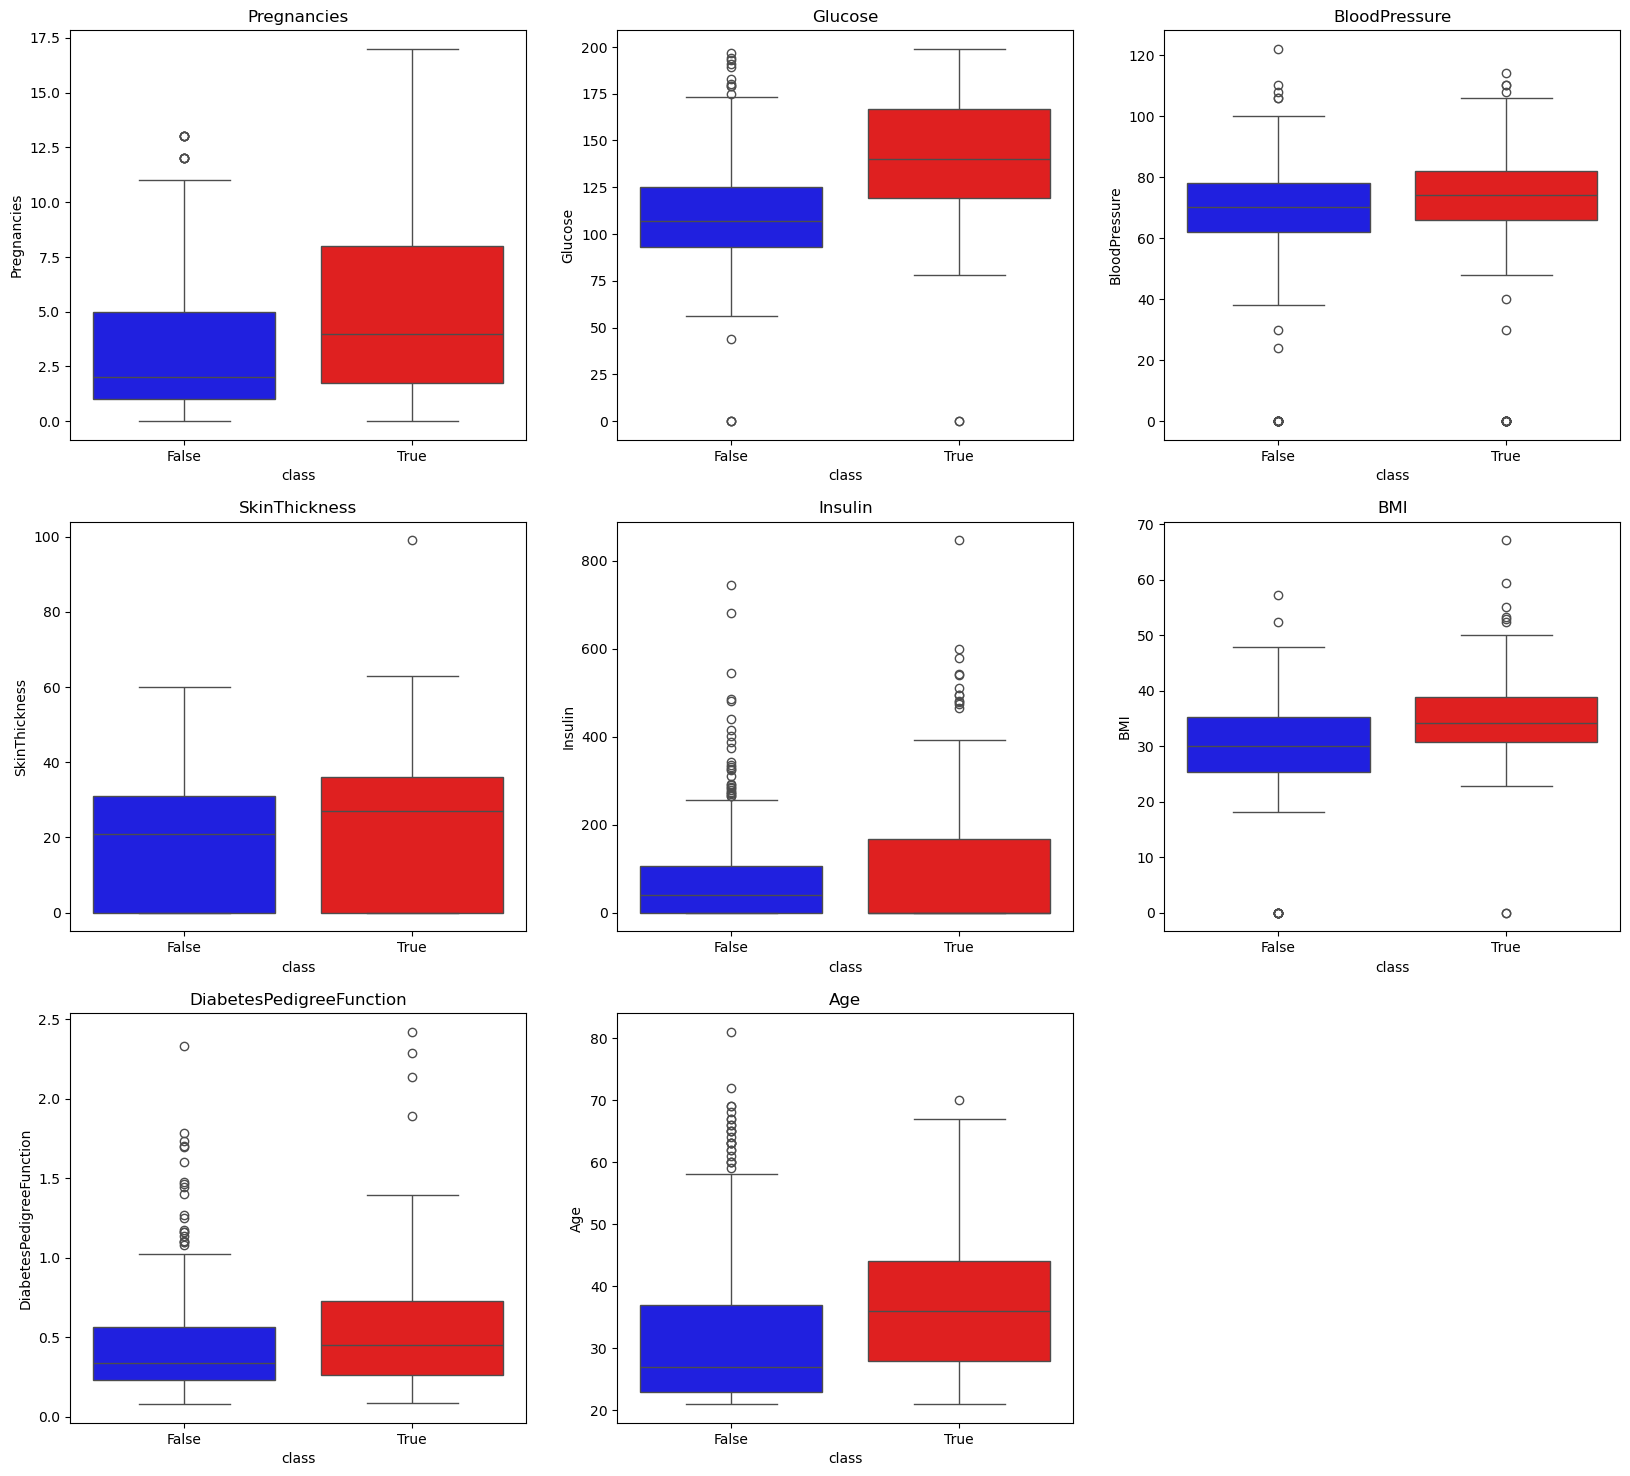

In [6]:
# Create the grid for the boxplots
fig, axes = plt.subplots(8, 3, figsize=(20, 50))
axes = axes.flatten()

# Create the boxplots
for i, feature in enumerate(feature_names):
    sns.boxplot(x='Outcome', y=feature, data=df_diabetes, hue='Outcome', ax=axes[i], palette={1: 'red', 0: 'blue'})
    axes[i].set_title(feature)
    axes[i].set_xlabel('class',  fontsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)
    axes[i].legend_.remove()

for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [7]:
# Replace invalid zeros
invalid_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_diabetes[invalid_zeros] = df_diabetes[invalid_zeros].replace(0, np.nan)

In [8]:
# Extract the feature names
X = df_diabetes[feature_names]
y = df_diabetes['Outcome']

In [9]:
# Outlier Blood Pressure
outlier_row = df_diabetes[df_diabetes['BloodPressure'] < 40]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
18             1    103.0           30.0           38.0     83.0  43.3   
125            1     88.0           30.0           42.0     99.0  55.0   
597            1     89.0           24.0           19.0     25.0  27.8   
599            1    109.0           38.0           18.0    120.0  23.1   

     DiabetesPedigreeFunction  Age  Outcome  
18                      0.183   33        0  
125                     0.496   26        1  
597                     0.559   21        0  
599                     0.407   26        0  


In [10]:
# Replace the extreme outliers and erroneous values of the feature diabetes
df_diabetes.loc[df_diabetes['BloodPressure'] < 40, 'BloodPressure'] = np.nan

In [11]:
# Outlier skin thickness
outlier_row = df_diabetes[df_diabetes['SkinThickness'] == 99]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
579            2    197.0           70.0           99.0      NaN  34.7   

     DiabetesPedigreeFunction  Age  Outcome  
579                     0.575   62        1  


In [12]:
# Replace the extreme outliers and erroneous values of the feature skin thickness
df_diabetes.loc[df_diabetes['SkinThickness'] == 99, 'SkinThickness'] = np.nan

In [13]:
# Outlier Insulin
outlier_row = df_diabetes[df_diabetes['Insulin'] > 400]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
8              2    197.0           70.0           45.0    543.0  30.5   
13             1    189.0           60.0           23.0    846.0  30.1   
111            8    155.0           62.0           26.0    495.0  34.0   
153            1    153.0           82.0           42.0    485.0  40.6   
186            8    181.0           68.0           36.0    495.0  30.1   
220            0    177.0           60.0           29.0    478.0  34.6   
228            4    197.0           70.0           39.0    744.0  36.7   
247            0    165.0           90.0           33.0    680.0  52.3   
248            9    124.0           70.0           33.0    402.0  35.4   
286            5    155.0           84.0           44.0    545.0  38.7   
370            3    173.0           82.0           48.0    465.0  38.4   
392            1    131.0           64.0           14.0    415.0  23.7   
409            1    172.0           68

In [14]:
# Replace the extreme outliers and erroneous values of the feature insulin
df_diabetes.loc[df_diabetes['Insulin'] > 400, 'Insulin'] = np.nan

In [15]:
# Outlier BMI?
outlier_row = df_diabetes[df_diabetes['BMI'] > 60]
print(outlier_row)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
177            0    129.0          110.0           46.0    130.0  67.1   

     DiabetesPedigreeFunction  Age  Outcome  
177                     0.319   26        1  


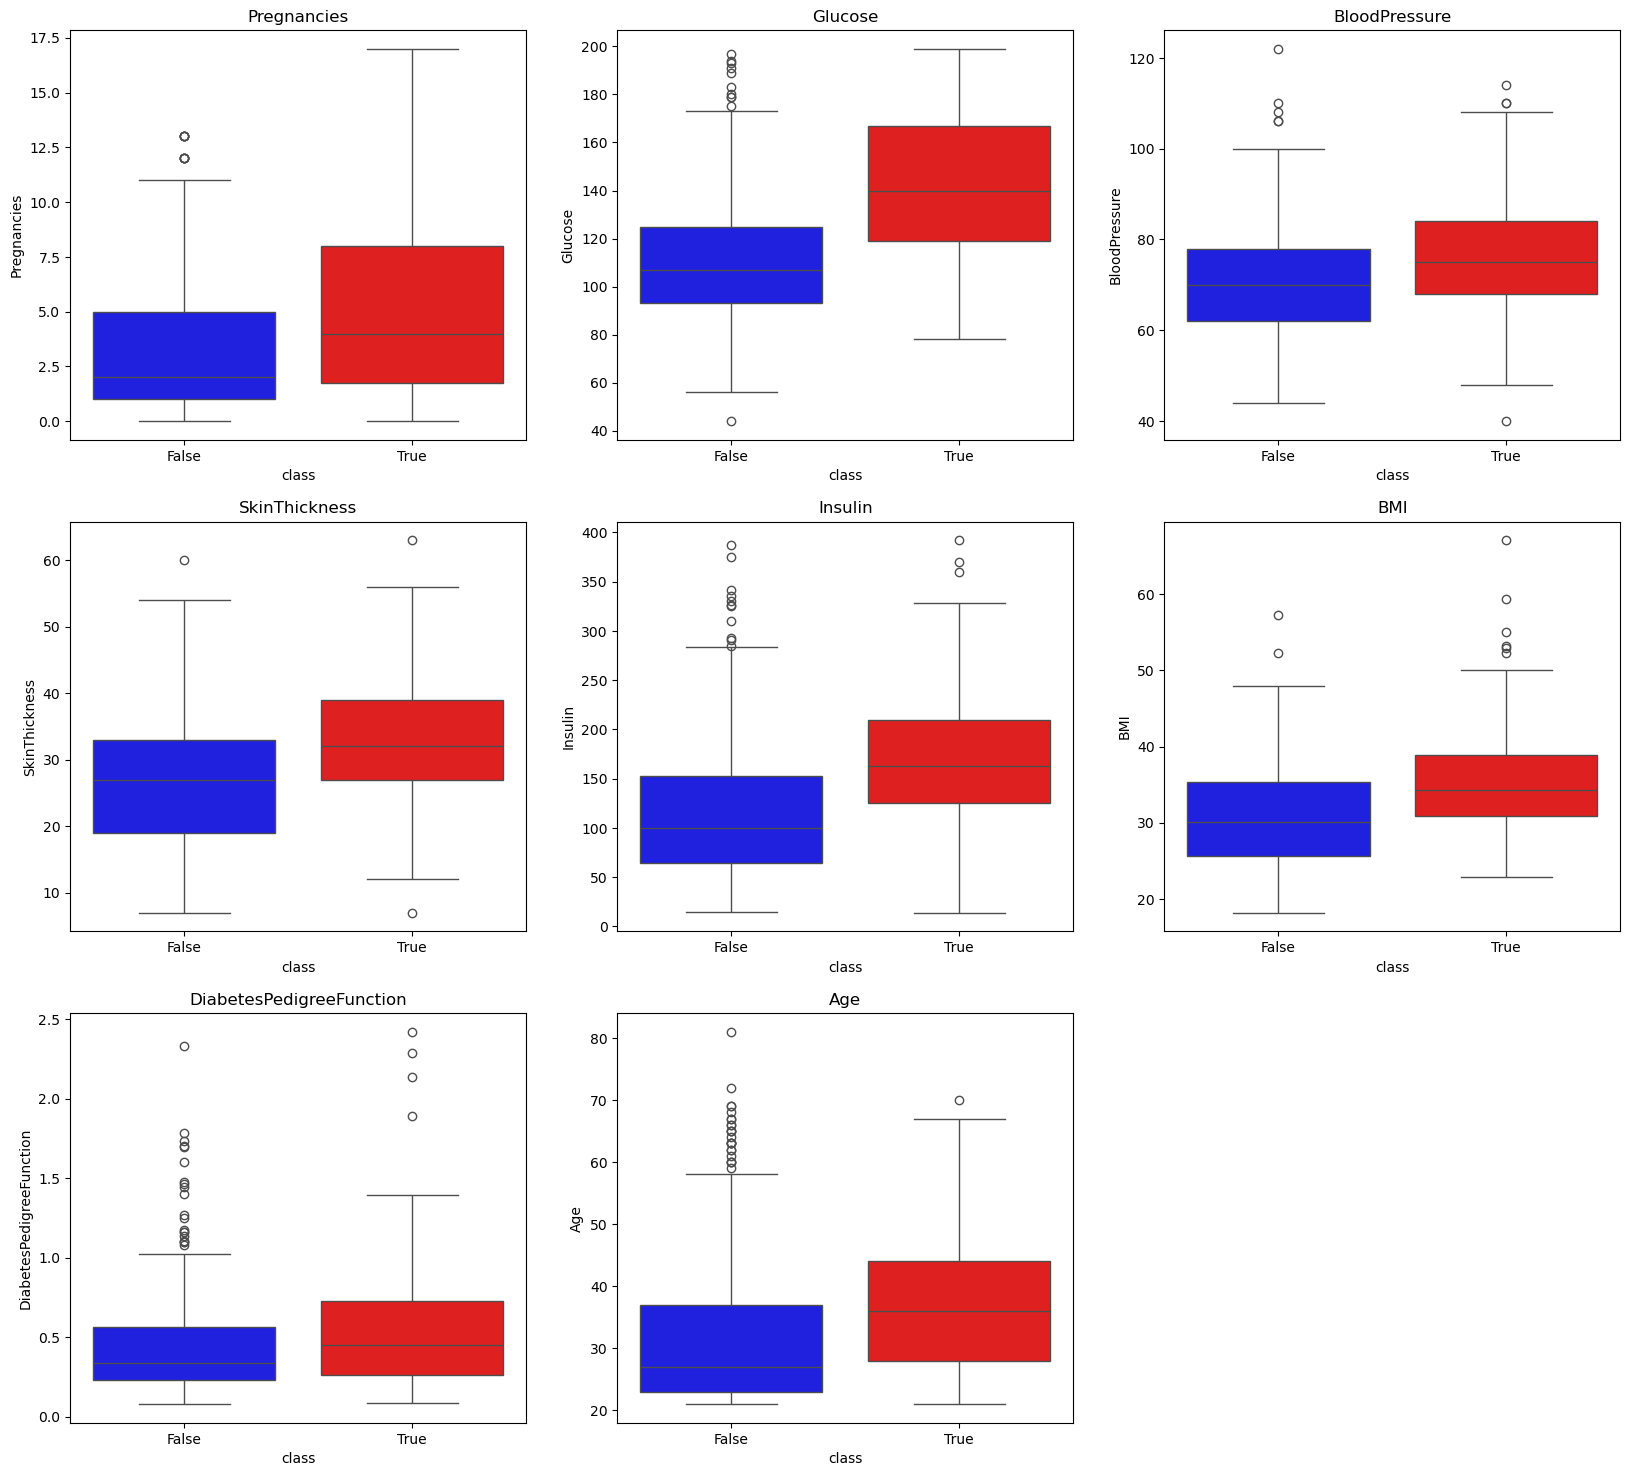

In [16]:
# Create the grid for the boxplots
fig, axes = plt.subplots(8, 3, figsize=(20, 50))
axes = axes.flatten()

# Create the boxplots
for i, feature in enumerate(feature_names):
    sns.boxplot(x='Outcome', y=feature, data=df_diabetes, hue='Outcome', ax=axes[i], palette={1: 'red', 0: 'blue'})
    axes[i].set_title(feature)
    axes[i].set_xlabel('class',  fontsize=10)
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'], fontsize=10)
    axes[i].set_ylabel(feature, fontsize=10)
    axes[i].legend_.remove()

for j in range(len(feature_names), len(axes)):
    fig.delaxes(axes[j])

plt.show()

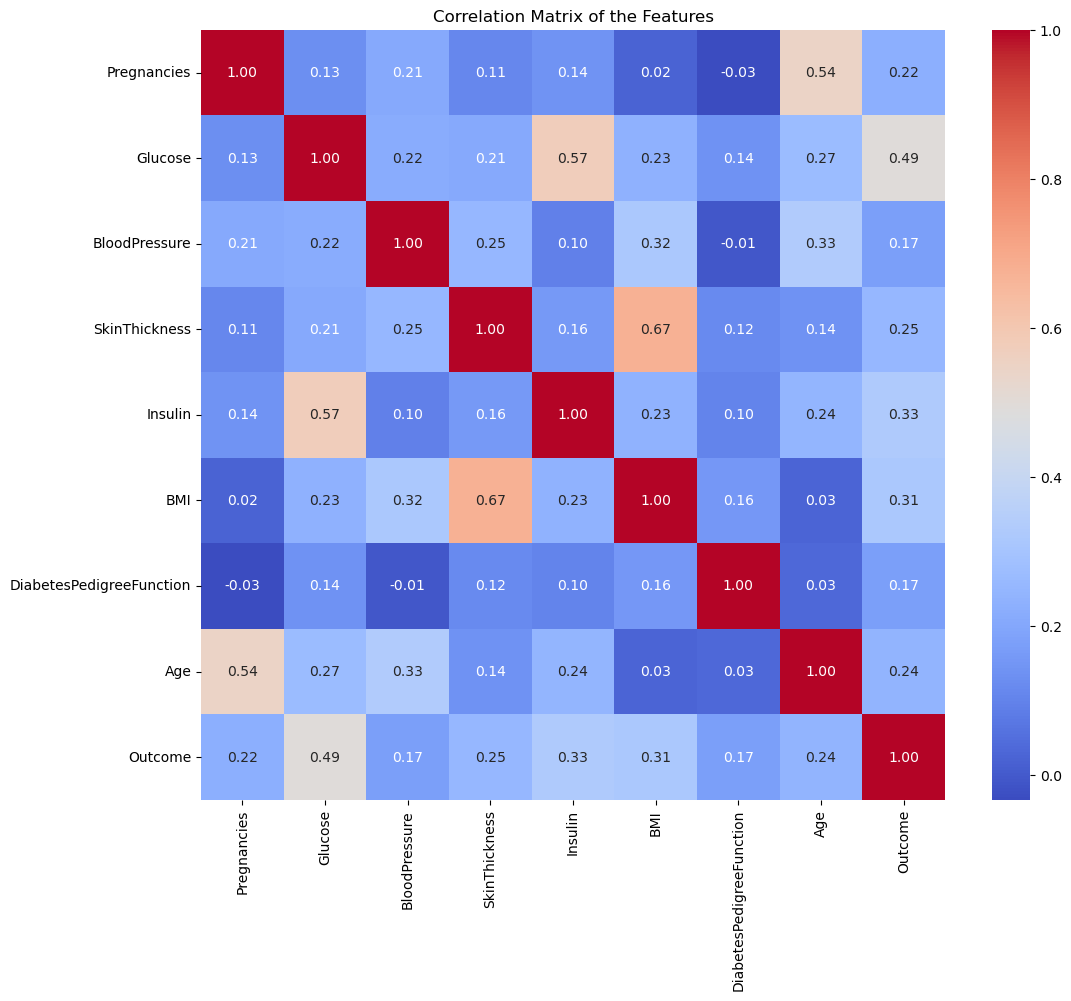

In [17]:
# Create a correlation matrix

corr_matrix = df_diabetes.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of the Features')
plt.show()

### 1.3 Prepare the data

In [18]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [19]:
# Checking the shape of the feature datasets
X_train.shape, X_val.shape, X_test.shape

((460, 8), (154, 8), (154, 8))

In [20]:
# Define a preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [21]:
# Proprocess the data using the preprocessing pipeline
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_val_preprocessed = preprocessing_pipeline.transform(X_val)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

In [22]:
# Convert  labels to NumPy array
y_train_array = y_train.to_numpy()
y_val_array = y_val.to_numpy()
y_test_array = y_test.to_numpy()

In [23]:
# Convert data and labels to PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_preprocessed, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

## 2. Implement models

### 2.1 Useful functions

In [24]:
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001, 0.0001],
    'batch_size': [32, 64, 128, 256],
    'optimizer': ['sgd', 'adam', 'rmsprop']
}

In [25]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


In [26]:
def evaluate_model(model, test_loader, device, loss_type='bce'):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()

            predicted = torch.sign(outputs) if loss_type == 'hinge' else (outputs > 0.5).float()
            all_preds.extend(predicted.cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    recall = recall_score(all_targets, all_preds, average='macro', zero_division=1)
    balanced_accuracy = balanced_accuracy_score(all_targets, all_preds)
    class_report = classification_report(all_targets, all_preds, output_dict=True, zero_division=1)

    print(f"Recall: {recall}, Balanced Accuracy: {balanced_accuracy}")
    return recall, balanced_accuracy, class_report


In [27]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, device, epochs=20, patience=3, loss_type='bce'):
    model.train()
    
    early_stopping = EarlyStopping(patience=patience, delta=0)
    
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # For Hinge Loss, labels are -1 and 1
            if loss_type == 'hinge':
                targets = 2 * targets - 1
                
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Accuracy based on the loss type
            if loss_type == 'hinge':
                predicted = torch.sign(outputs)
            else:
                predicted = (outputs > 0.5).float()
            
            correct_train += (predicted == targets).sum().item()
            total_train += targets.size(0)

        average_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_loss_history.append(average_train_loss)
        train_accuracy_history.append(train_accuracy)

        # Validation phase
        model.eval()
        recall, balanced_accuracy, _ = evaluate_model(model, val_loader, device, loss_type=loss_type)
        
        val_loss = 1 - balanced_accuracy
        val_loss_history.append(val_loss)
        val_accuracy_history.append(balanced_accuracy)

        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history


In [28]:
def get_optimizer(optimizer_name, model, lr):
    if optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")


In [29]:
def grid_search(model_constructor, X_train, y_train, X_val, y_val, input_size, loss_fn_name, param_grid, device, epochs=20, patience=5):
    best_params = None
    best_balanced_accuracy = 0
    results = []
    
    for lr in param_grid['learning_rate']:
        for batch_size in param_grid['batch_size']:
            for optimizer_name in param_grid['optimizer']:
                train_dataset = TensorDataset(X_train, y_train)
                val_dataset = TensorDataset(X_val, y_val)
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                model = model_constructor(input_size).to(device)
                optimizer = get_optimizer(optimizer_name, model, lr)

                # Loss function selection
                if loss_fn_name == 'bce':
                    loss_fn = nn.BCELoss()
                elif loss_fn_name == 'hinge':
                    loss_fn = nn.HingeEmbeddingLoss()
                elif loss_fn_name == 'mse':
                    loss_fn = nn.MSELoss()
                else:
                    raise ValueError(f"Unknown Loss function: {loss_fn_name}")

                # Train model
                train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = train_model(
                    model, optimizer, loss_fn, train_loader, val_loader, device, epochs=epochs, patience=patience, loss_type=loss_fn_name
                )

                # Evaluate the model
                recall, balanced_accuracy, class_report = evaluate_model(model, val_loader, device, loss_type=loss_fn_name)

                result = {
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'optimizer': optimizer_name,
                    'train_loss': train_loss_history,
                    'val_loss': val_loss_history,
                    'train_accuracy': train_accuracy_history,
                    'val_accuracy': val_accuracy_history,
                    'recall': recall,
                    'balanced_accuracy': balanced_accuracy,
                    'classification_report': class_report
                }
                results.append(result)

                # Update best model
                if balanced_accuracy > best_balanced_accuracy:
                    best_balanced_accuracy = balanced_accuracy
                    best_params = result

    return best_params, results


In [30]:
def print_best_model_results(best_params):

    # Print best parameters based on balanced accuracy
    print("Best parameters (based on balanced accuracy):")
    print(f" Learning Rate: {best_params['learning_rate']}")
    print(f" Batch Size: {best_params['batch_size']}")
    print(f" Optimizer: {best_params['optimizer']}")
    print(f"Balanced Accuracy: {best_params['balanced_accuracy']}")
    print(f"Recall: {best_params['recall']}")
    print(f"Classification report for best model (based on balanced accuracy):\n {best_params['classification_report']}")


In [31]:
# Set the device for PyTorch (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def plot_accuracy_and_loss(train_loss, val_loss, train_accuracy, val_accuracy):
    epochs = range(1, len(train_loss) + 1)
    
    # Create a 1x2 grid of subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training and validation loss
    axs[0].plot(epochs, train_loss, label="Training Loss", color="blue")
    axs[0].plot(epochs, train_accuracy, label="Training Accuracy", color="orange")
    axs[0].set_title("Training Accuracy and Loss")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss/Accuracy")
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(epochs, val_loss, label="Validation Loss", color="blue")
    axs[1].plot(epochs, val_accuracy, label="Validation Accuracy", color="orange")
    axs[1].set_title("Validation Accuracy and Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss/Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


### 2.2 Activation function: Sigmoid

In [33]:
class Perceptron_sigmoid(nn.Module):
    def __init__(self, input_size):
        super(Perceptron_sigmoid, self).__init__()
        self.fc = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.fc(x)) 

In [34]:
best_params_sigmoid, results_sigmoid = grid_search(
    Perceptron_sigmoid,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_train_tensor.shape[1], 'bce', param_grid, device, epochs=500, patience=5)


Recall: 0.7516666666666667, Balanced Accuracy: 0.7516666666666667
Recall: 0.7731481481481481, Balanced Accuracy: 0.7731481481481481
Recall: 0.7803703703703704, Balanced Accuracy: 0.7803703703703704
Recall: 0.7761111111111111, Balanced Accuracy: 0.7761111111111111
Recall: 0.7675925925925926, Balanced Accuracy: 0.7675925925925926
Recall: 0.7733333333333333, Balanced Accuracy: 0.7733333333333333
Recall: 0.7740740740740741, Balanced Accuracy: 0.7740740740740741
Recall: 0.7555555555555555, Balanced Accuracy: 0.7555555555555555
Recall: 0.7555555555555555, Balanced Accuracy: 0.7555555555555555
Recall: 0.7235185185185186, Balanced Accuracy: 0.7235185185185186
Recall: 0.7335185185185186, Balanced Accuracy: 0.7335185185185186
Recall: 0.769074074074074, Balanced Accuracy: 0.769074074074074
Recall: 0.737037037037037, Balanced Accuracy: 0.737037037037037
Recall: 0.737037037037037, Balanced Accuracy: 0.737037037037037
Recall: 0.7498148148148148, Balanced Accuracy: 0.7498148148148148
Recall: 0.764814

In [35]:
print_best_model_results(best_params_sigmoid)

Best parameters (based on balanced accuracy):
 Learning Rate: 0.01
 Batch Size: 128
 Optimizer: adam
Balanced Accuracy: 0.8068518518518519
Recall: 0.8068518518518519
Classification report for best model (based on balanced accuracy):
 {'0.0': {'precision': 0.8504672897196262, 'recall': 0.91, 'f1-score': 0.8792270531400966, 'support': 100.0}, '1.0': {'precision': 0.8085106382978723, 'recall': 0.7037037037037037, 'f1-score': 0.7524752475247525, 'support': 54.0}, 'accuracy': 0.8376623376623377, 'macro avg': {'precision': 0.8294889640087493, 'recall': 0.8068518518518519, 'f1-score': 0.8158511503324246, 'support': 154.0}, 'weighted avg': {'precision': 0.835755217143167, 'recall': 0.8376623376623377, 'f1-score': 0.8347816148074434, 'support': 154.0}}


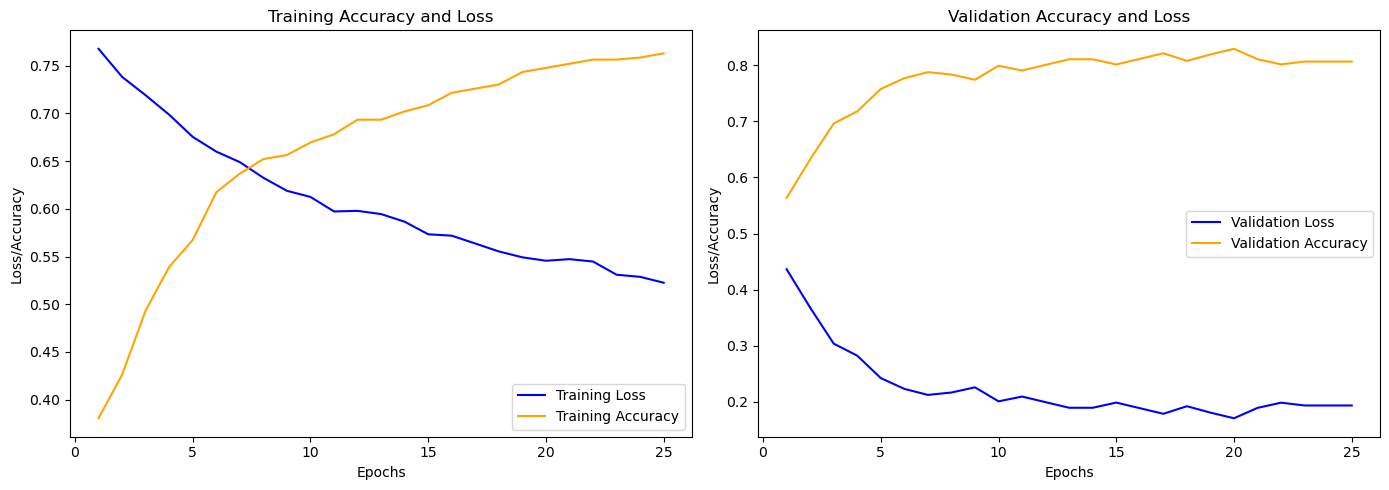

In [36]:
plot_accuracy_and_loss(best_params_sigmoid['train_loss'], best_params_sigmoid['val_loss'], best_params_sigmoid['train_accuracy'], best_params_sigmoid['val_accuracy'])

### 2.3 Activation function: Tanh

In [37]:
class Perceptron_tanh(nn.Module):
    def __init__(self, input_size):
        super(Perceptron_tanh, self).__init__()
        self.fc = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.tanh(self.fc(x)) 

In [38]:
best_params_tanh, results_tanh = grid_search(
    Perceptron_tanh,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_train_tensor.shape[1], 'mse', param_grid, device, epochs=200, patience=5)


Recall: 0.7340740740740741, Balanced Accuracy: 0.7340740740740741
Recall: 0.7462962962962962, Balanced Accuracy: 0.7462962962962962
Recall: 0.7455555555555555, Balanced Accuracy: 0.7455555555555555
Recall: 0.7583333333333333, Balanced Accuracy: 0.7583333333333333
Recall: 0.7575925925925926, Balanced Accuracy: 0.7575925925925926
Recall: 0.732037037037037, Balanced Accuracy: 0.732037037037037
Recall: 0.7512962962962964, Balanced Accuracy: 0.7512962962962964
Recall: 0.749074074074074, Balanced Accuracy: 0.749074074074074
Recall: 0.759074074074074, Balanced Accuracy: 0.759074074074074
Recall: 0.747037037037037, Balanced Accuracy: 0.747037037037037
Recall: 0.7505555555555556, Balanced Accuracy: 0.7505555555555556
Recall: 0.7405555555555556, Balanced Accuracy: 0.7405555555555556
Recall: 0.7555555555555555, Balanced Accuracy: 0.7555555555555555
Recall: 0.7277777777777779, Balanced Accuracy: 0.7277777777777779
Recall: 0.7277777777777779, Balanced Accuracy: 0.7277777777777779
Recall: 0.74407407

In [39]:
print_best_model_results(best_params_tanh)

Best parameters (based on balanced accuracy):
 Learning Rate: 0.001
 Batch Size: 64
 Optimizer: rmsprop
Balanced Accuracy: 0.7740740740740741
Recall: 0.7740740740740741
Classification report for best model (based on balanced accuracy):
 {'0.0': {'precision': 0.8256880733944955, 'recall': 0.9, 'f1-score': 0.861244019138756, 'support': 100.0}, '1.0': {'precision': 0.7777777777777778, 'recall': 0.6481481481481481, 'f1-score': 0.7070707070707071, 'support': 54.0}, 'accuracy': 0.8116883116883117, 'macro avg': {'precision': 0.8017329255861366, 'recall': 0.7740740740740741, 'f1-score': 0.7841573631047316, 'support': 154.0}, 'weighted avg': {'precision': 0.808888359347075, 'recall': 0.8116883116883117, 'f1-score': 0.807183247374635, 'support': 154.0}}


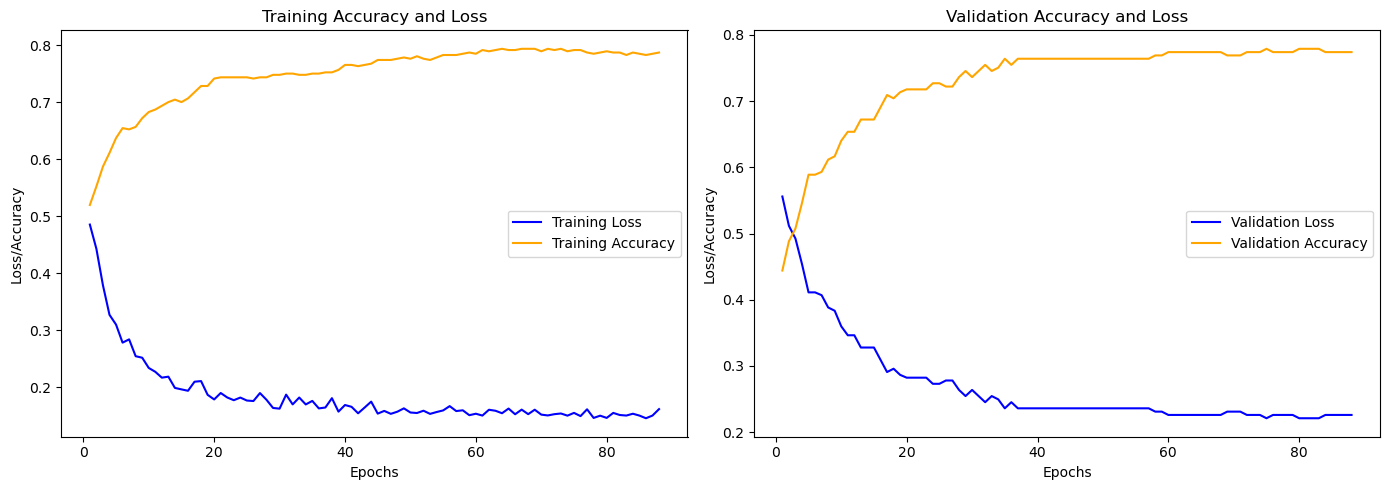

In [40]:
plot_accuracy_and_loss(best_params_tanh['train_loss'], best_params_tanh['val_loss'], best_params_tanh['train_accuracy'], best_params_tanh['val_accuracy'])

### 2.3 Activation function: ReLU

In [41]:
class Perceptron_ReLU(nn.Module):
    def __init__(self, input_size):
        super(Perceptron_ReLU, self).__init__()
        self.fc = torch.nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.relu(self.fc(x)) 

In [42]:
best_params_relu, results_relu = grid_search(
    Perceptron_ReLU,
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    X_train_tensor.shape[1], 'hinge', param_grid, device, epochs=200, patience=10)


Recall: 0.34129629629629626, Balanced Accuracy: 0.34129629629629626
Recall: 0.3448148148148148, Balanced Accuracy: 0.3448148148148148
Recall: 0.3255555555555556, Balanced Accuracy: 0.3255555555555556
Recall: 0.3162962962962963, Balanced Accuracy: 0.3162962962962963
Recall: 0.3255555555555556, Balanced Accuracy: 0.3255555555555556
Recall: 0.3440740740740741, Balanced Accuracy: 0.3440740740740741
Recall: 0.3440740740740741, Balanced Accuracy: 0.3440740740740741
Recall: 0.35333333333333333, Balanced Accuracy: 0.35333333333333333
Recall: 0.36259259259259263, Balanced Accuracy: 0.36259259259259263
Recall: 0.36259259259259263, Balanced Accuracy: 0.36259259259259263
Recall: 0.3490740740740741, Balanced Accuracy: 0.3490740740740741
Recall: 0.35833333333333334, Balanced Accuracy: 0.35833333333333334
Recall: 0.3448148148148148, Balanced Accuracy: 0.3448148148148148
Recall: 0.3540740740740741, Balanced Accuracy: 0.3540740740740741
Recall: 0.3540740740740741, Balanced Accuracy: 0.3540740740740741


In [43]:
print_best_model_results(best_params_relu)

Best parameters (based on balanced accuracy):
 Learning Rate: 0.001
 Batch Size: 256
 Optimizer: rmsprop
Balanced Accuracy: 0.7472222222222222
Recall: 0.7472222222222222
Classification report for best model (based on balanced accuracy):
 {'0.0': {'precision': 0.9482758620689655, 'recall': 0.55, 'f1-score': 0.6962025316455697, 'support': 100.0}, '1.0': {'precision': 0.53125, 'recall': 0.9444444444444444, 'f1-score': 0.68, 'support': 54.0}, 'accuracy': 0.6883116883116883, 'macro avg': {'precision': 0.7397629310344828, 'recall': 0.7472222222222222, 'f1-score': 0.6881012658227849, 'support': 154.0}, 'weighted avg': {'precision': 0.8020460143304972, 'recall': 0.6883116883116883, 'f1-score': 0.6905211244451751, 'support': 154.0}}


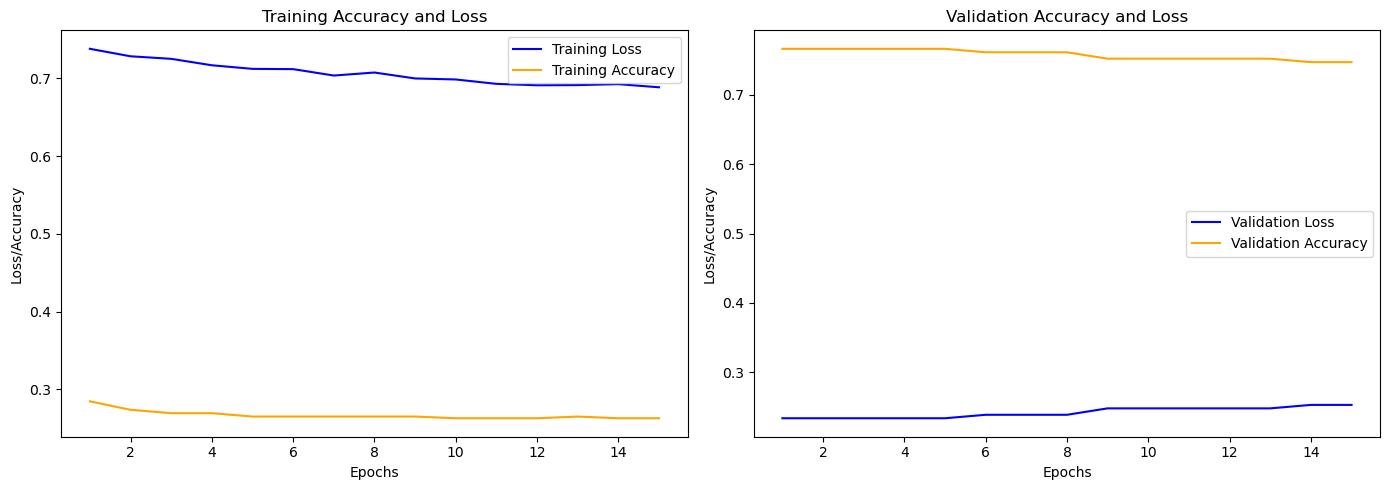

In [44]:
plot_accuracy_and_loss(best_params_relu['train_loss'], best_params_relu['val_loss'], best_params_relu['train_accuracy'], best_params_relu['val_accuracy'])

## 3. Best model evaluation

In [45]:
# Combine train and validation data for final training
train_val_dataset = TensorDataset(torch.cat((X_train_tensor, X_val_tensor)), torch.cat((y_train_tensor, y_val_tensor)))
train_val_loader = DataLoader(train_val_dataset, batch_size=best_params_sigmoid['batch_size'], shuffle=True)

In [46]:
best_model = Perceptron_sigmoid(X_train_tensor.shape[1]).to(device)
optimizer = get_optimizer(best_params_sigmoid['optimizer'], best_model, best_params_sigmoid['learning_rate'])
loss_fn = nn.BCELoss()

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=best_params_sigmoid['batch_size'], shuffle=False)
test_recall, test_balanced_acc, test_class_report = evaluate_model(best_model, test_loader, device)

train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history = train_model(
                    best_model, optimizer, loss_fn, train_val_loader, test_loader, device, epochs=200, patience=5, loss_type='bce')

Recall: 0.4318518518518519, Balanced Accuracy: 0.4318518518518519
Recall: 0.4861111111111111, Balanced Accuracy: 0.4861111111111111
Recall: 0.5566666666666666, Balanced Accuracy: 0.5566666666666666
Recall: 0.63, Balanced Accuracy: 0.63
Recall: 0.6342592592592593, Balanced Accuracy: 0.6342592592592593
Recall: 0.6612962962962963, Balanced Accuracy: 0.6612962962962963
Recall: 0.6662962962962963, Balanced Accuracy: 0.6662962962962963
Recall: 0.6755555555555556, Balanced Accuracy: 0.6755555555555556
Recall: 0.6762962962962963, Balanced Accuracy: 0.6762962962962963
Recall: 0.6762962962962963, Balanced Accuracy: 0.6762962962962963
Recall: 0.672037037037037, Balanced Accuracy: 0.672037037037037
Recall: 0.672037037037037, Balanced Accuracy: 0.672037037037037
Recall: 0.6770370370370371, Balanced Accuracy: 0.6770370370370371
Recall: 0.6770370370370371, Balanced Accuracy: 0.6770370370370371
Recall: 0.682037037037037, Balanced Accuracy: 0.682037037037037
Recall: 0.682037037037037, Balanced Accuracy

In [47]:
recall, balanced_accuracy, class_report = evaluate_model(best_model, test_loader, device, loss_type='bce')

Recall: 0.6727777777777778, Balanced Accuracy: 0.6727777777777778


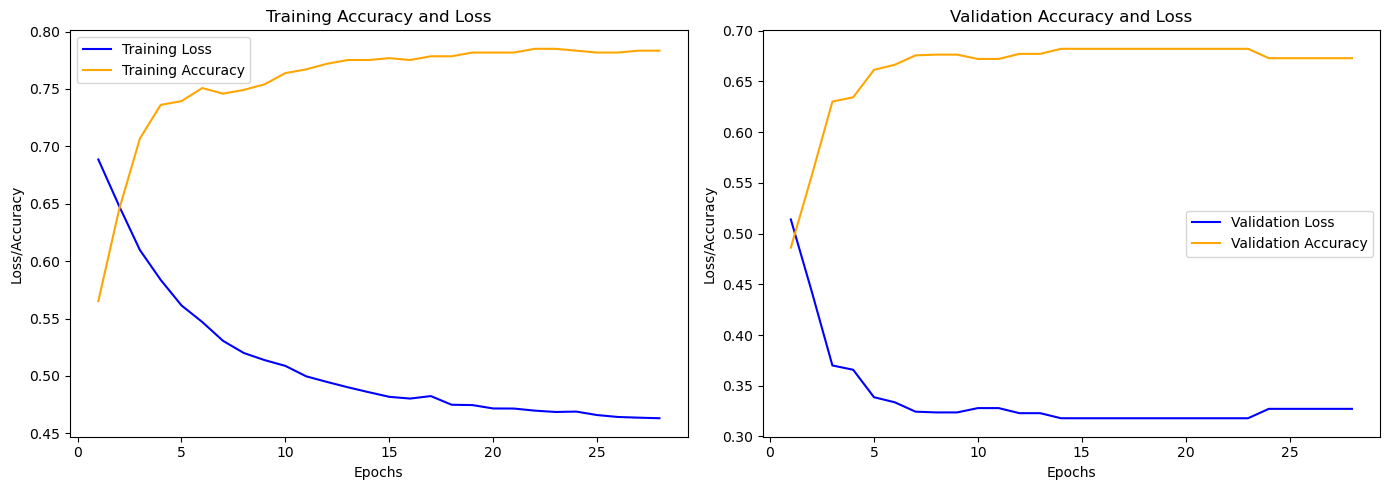

In [48]:
plot_accuracy_and_loss(train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history)